In [ ]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sqlalchemy import create_engine
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [ ]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

In [ ]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
house_prices_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

# Data cleaning

In [ ]:

total_missing = house_prices_df.isnull().sum().sort_values(ascending=False)
percent_missing = (house_prices_df.isnull().sum()/house_prices_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])
missing_data.head(25)

,Total,Percent
poolqc,1453,0.995205
miscfeature,1406,0.963014
alley,1369,0.937671
fence,1179,0.807534
fireplacequ,690,0.472603
lotfrontage,259,0.177397
garageyrblt,81,0.055479
garagecond,81,0.055479
garagetype,81,0.055479
garagefinish,81,0.055479


In [ ]:
#house_prices_df.fillna(value = 'NA', inplace=True)

In [ ]:
house_prices_df.poolqc.unique()

array([None, 'Ex', 'Fa', 'Gd'], dtype=object)

In [ ]:
non_numeric_columns = house_prices_df.select_dtypes(['object']).columns
print(non_numeric_columns)
print("The number of non-numerical columns is {}".format(len(non_numeric_columns)))

Index(['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation',
       'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual',
       'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal',
       'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature',
       'saletype', 'salecondition'],
      dtype='object')
The number of non-numerical columns is 43


In [ ]:
house_prices_df.street.value_counts()

Pave    1454
Grvl       6
Name: street, dtype: int64

In [ ]:

numeric_columns = house_prices_df.select_dtypes(['int64', 'float64']).columns
print(numeric_columns)
print("The number of numerical columns is {}".format(len(numeric_columns)))

Index(['id', 'mssubclass', 'lotfrontage', 'lotarea', 'overallqual',
       'overallcond', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1',
       'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'firstflrsf', 'secondflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd',
       'fireplaces', 'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf',
       'openporchsf', 'enclosedporch', 'threessnporch', 'screenporch',
       'poolarea', 'miscval', 'mosold', 'yrsold', 'saleprice'],
      dtype='object')
The number of numerical columns is 38


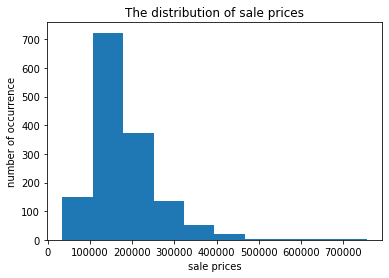

In [ ]:

plt.hist(house_prices_df.saleprice)
plt.title("The distribution of sale prices")
plt.xlabel("sale prices")
plt.ylabel("number of occurrence")
plt.show()

In [ ]:
total_missing = house_prices_df[numeric_columns].isnull().sum().sort_values(ascending=False)
percent_missing = (house_prices_df[numeric_columns].isnull().sum()/house_prices_df[numeric_columns].isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])
missing_data.head(5)

,Total,Percent
lotfrontage,259,0.177397
garageyrblt,81,0.055479
masvnrarea,8,0.005479
id,0,0.000000
openporchsf,0,0.000000


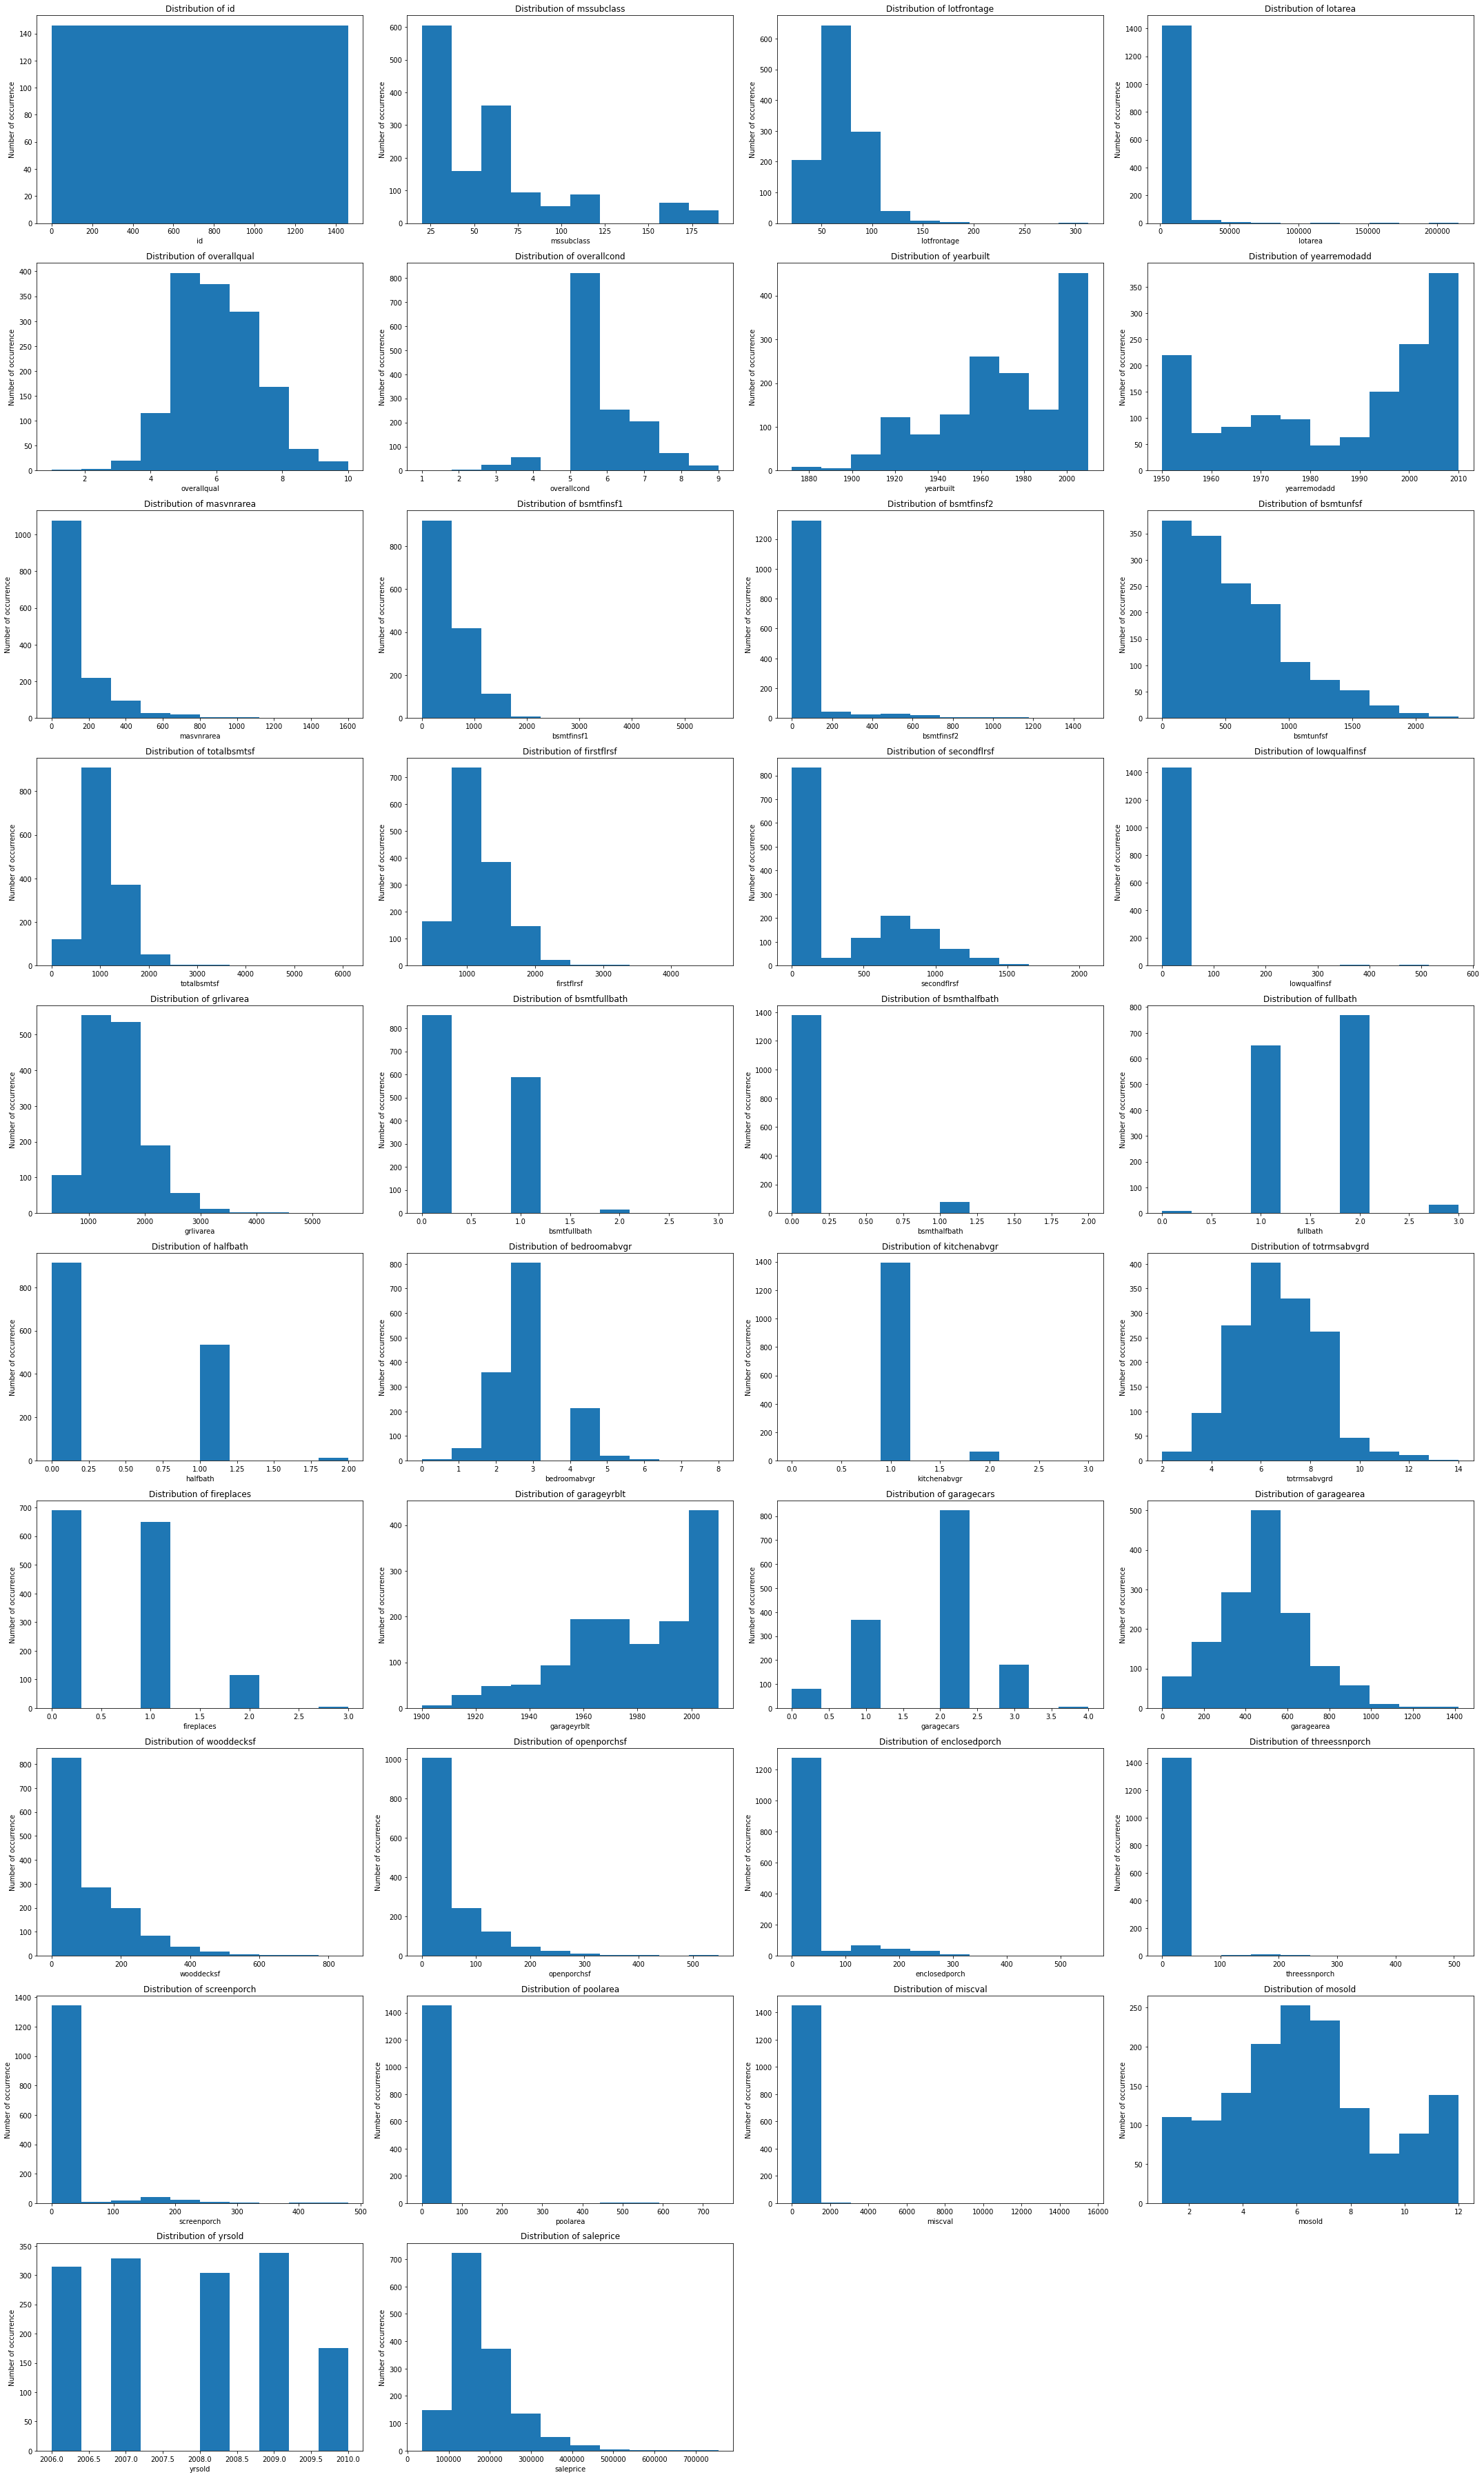

In [ ]:
plt.figure(figsize=(30,50))

for index, column in enumerate(numeric_columns):
    plt.subplot(10,4,index+1)
    plt.hist(house_prices_df[column])
    plt.title("Distribution of {}".format(column))
    plt.ylabel("Number of occurrence")
    plt.xlabel(column)
    

plt.tight_layout()
plt.show()

In [ ]:
#there are only 3 numeric variables with missing values. We will use mean value to fill lotfrontage, interpolate for garage year built
#and 0 for mason area
house_prices_df['lotfrontage'].fillna(house_prices_df['lotfrontage'].mean(), inplace= True)
house_prices_df['garageyrblt'].fillna(house_prices_df['garageyrblt'].interpolate(), inplace= True)
house_prices_df['masvnrarea'].fillna(0, inplace= True)

# Categorical variables

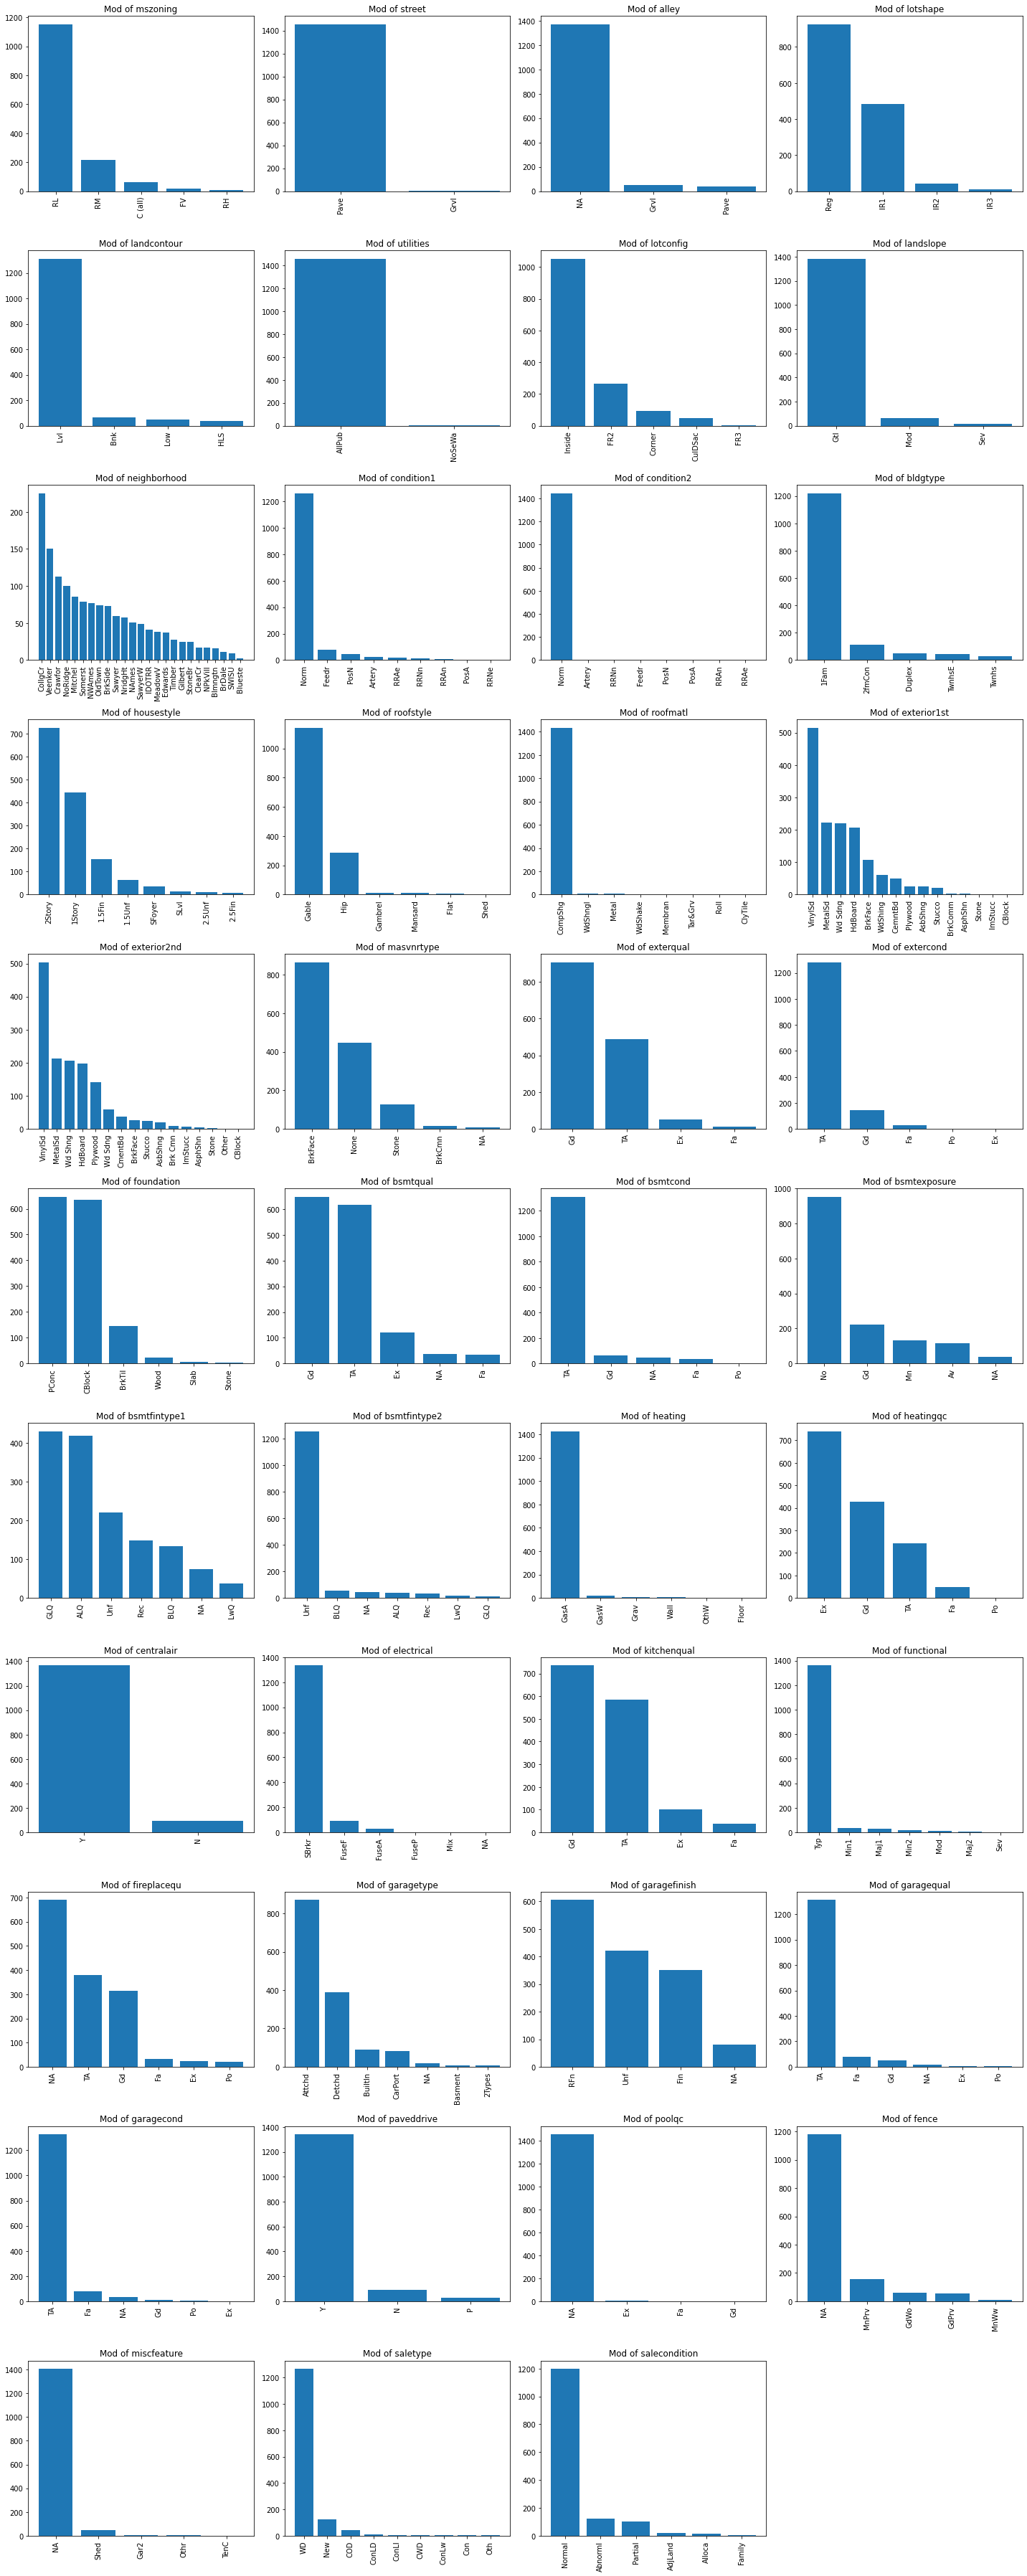

In [ ]:
# it appears that None identifies a separate category where feature is not present. 
house_prices_df.fillna(value = 'NA', inplace=True)


fig = plt.figure(figsize=(20,50))

for index, col in enumerate(non_numeric_columns):
    names = list(house_prices_df[col].unique())
    values = list(house_prices_df[col].value_counts())
    plt.subplot(11,4,index+1)

    plt.bar(names, values)
    plt.xticks(rotation='vertical')
    plt.title("Mod of {}".format(col))
    
plt.tight_layout()
plt.show()


# Outliers

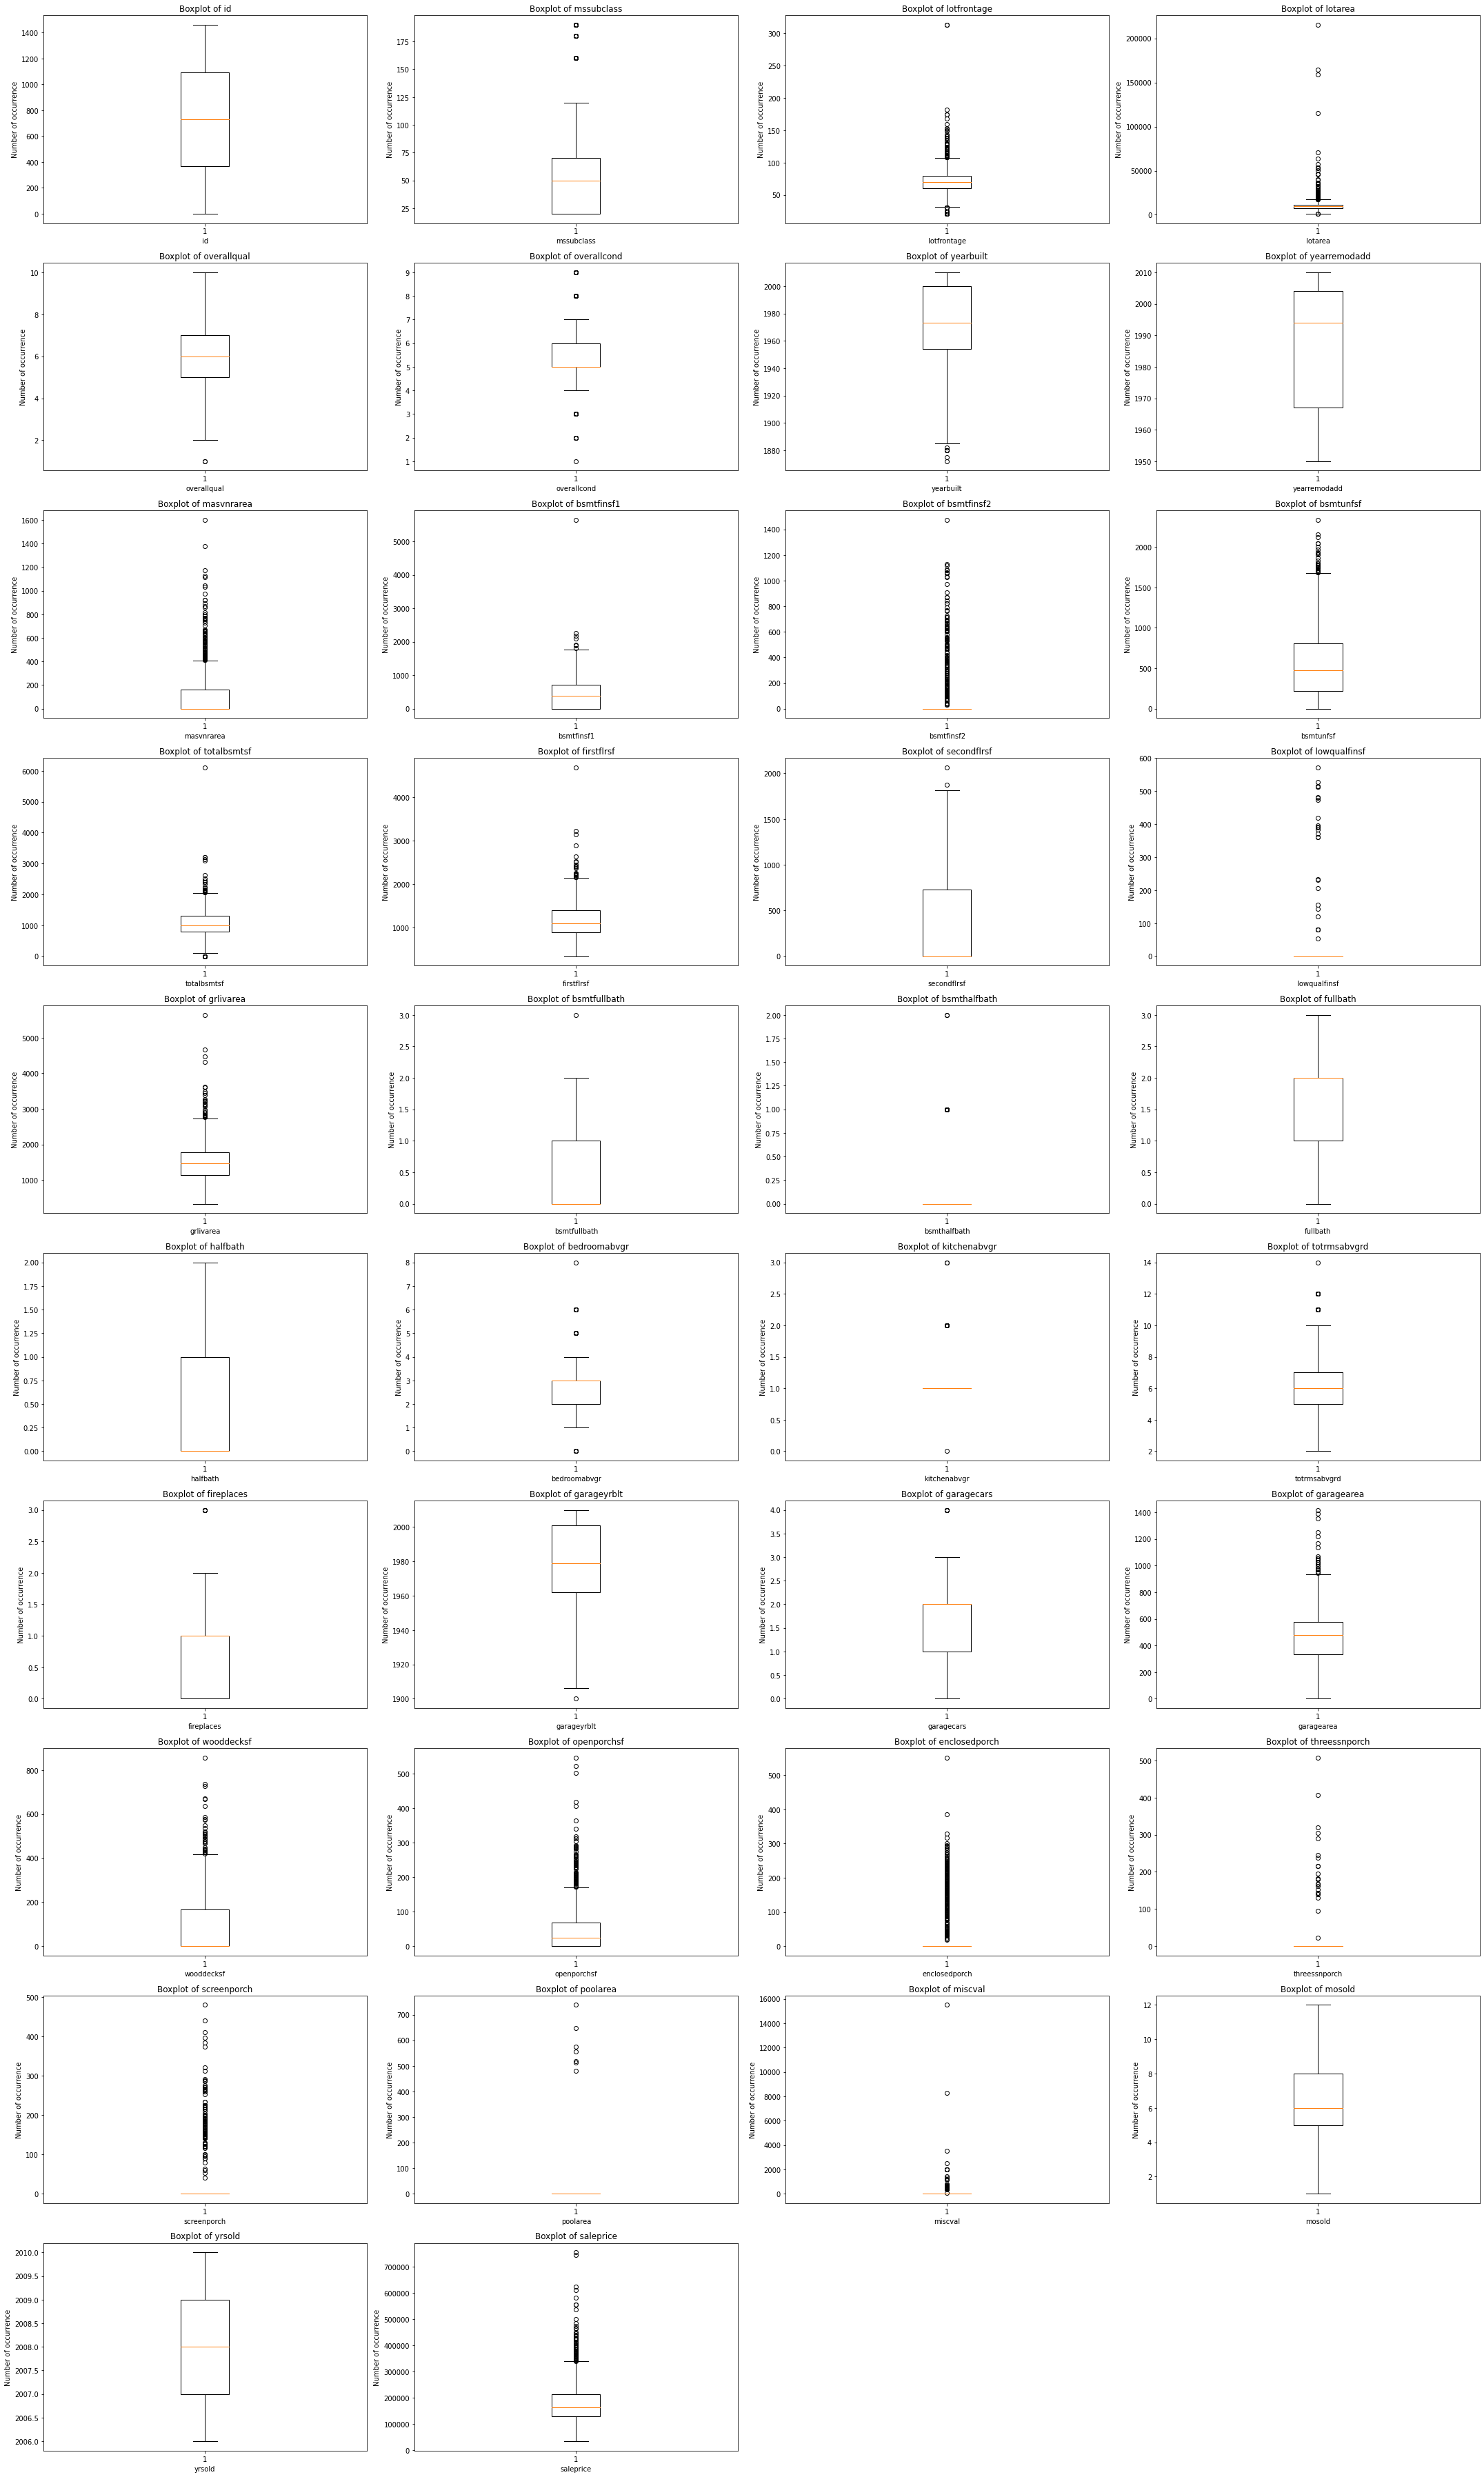

In [ ]:
plt.figure(figsize=(30,50))

for index, column in enumerate(numeric_columns):
    plt.subplot(10,4,index+1)
    plt.boxplot(house_prices_df[column])
    plt.title("Boxplot of {}".format(column))
    plt.ylabel("Number of occurrence")
    plt.xlabel(column)
    

plt.tight_layout()
plt.show()

it seems that outliers are natural part of the data, there are no unreasonable values.

# Feature engineering stage

In [ ]:
# boxcox transformation of saleprice, selecting features pearson correlation matrix, 
jarque_bera_test = stats.jarque_bera(house_prices_df['saleprice'])
jarque_bera_test

Jarque_beraResult(statistic=3438.8721241220583, pvalue=0.0)

In [ ]:
#house_prices_df['saleprice'],_=stats.boxcox(house_prices_df['saleprice'])
#jarque_bera_test = stats.jarque_bera(house_prices_df['saleprice'])
#jarque_bera_test

In [ ]:
#we normalized the data. selecting usefull features pearson correlation matrix:
np.abs(house_prices_df[numeric_columns].iloc[:,1:].corr().loc[:,"saleprice"]).sort_values(ascending=False)

saleprice        1.000000
overallqual      0.790982
grlivarea        0.708624
garagecars       0.640409
garagearea       0.623431
totalbsmtsf      0.613581
firstflrsf       0.605852
fullbath         0.560664
totrmsabvgrd     0.533723
yearbuilt        0.522897
yearremodadd     0.507101
masvnrarea       0.472614
garageyrblt      0.467106
fireplaces       0.466929
bsmtfinsf1       0.386420
lotfrontage      0.334901
wooddecksf       0.324413
secondflrsf      0.319334
openporchsf      0.315856
halfbath         0.284108
lotarea          0.263843
bsmtfullbath     0.227122
bsmtunfsf        0.214479
bedroomabvgr     0.168213
kitchenabvgr     0.135907
enclosedporch    0.128578
screenporch      0.111447
poolarea         0.092404
mssubclass       0.084284
overallcond      0.077856
mosold           0.046432
threessnporch    0.044584
yrsold           0.028923
lowqualfinsf     0.025606
miscval          0.021190
bsmthalfbath     0.016844
bsmtfinsf2       0.011378
Name: saleprice, dtype: float64

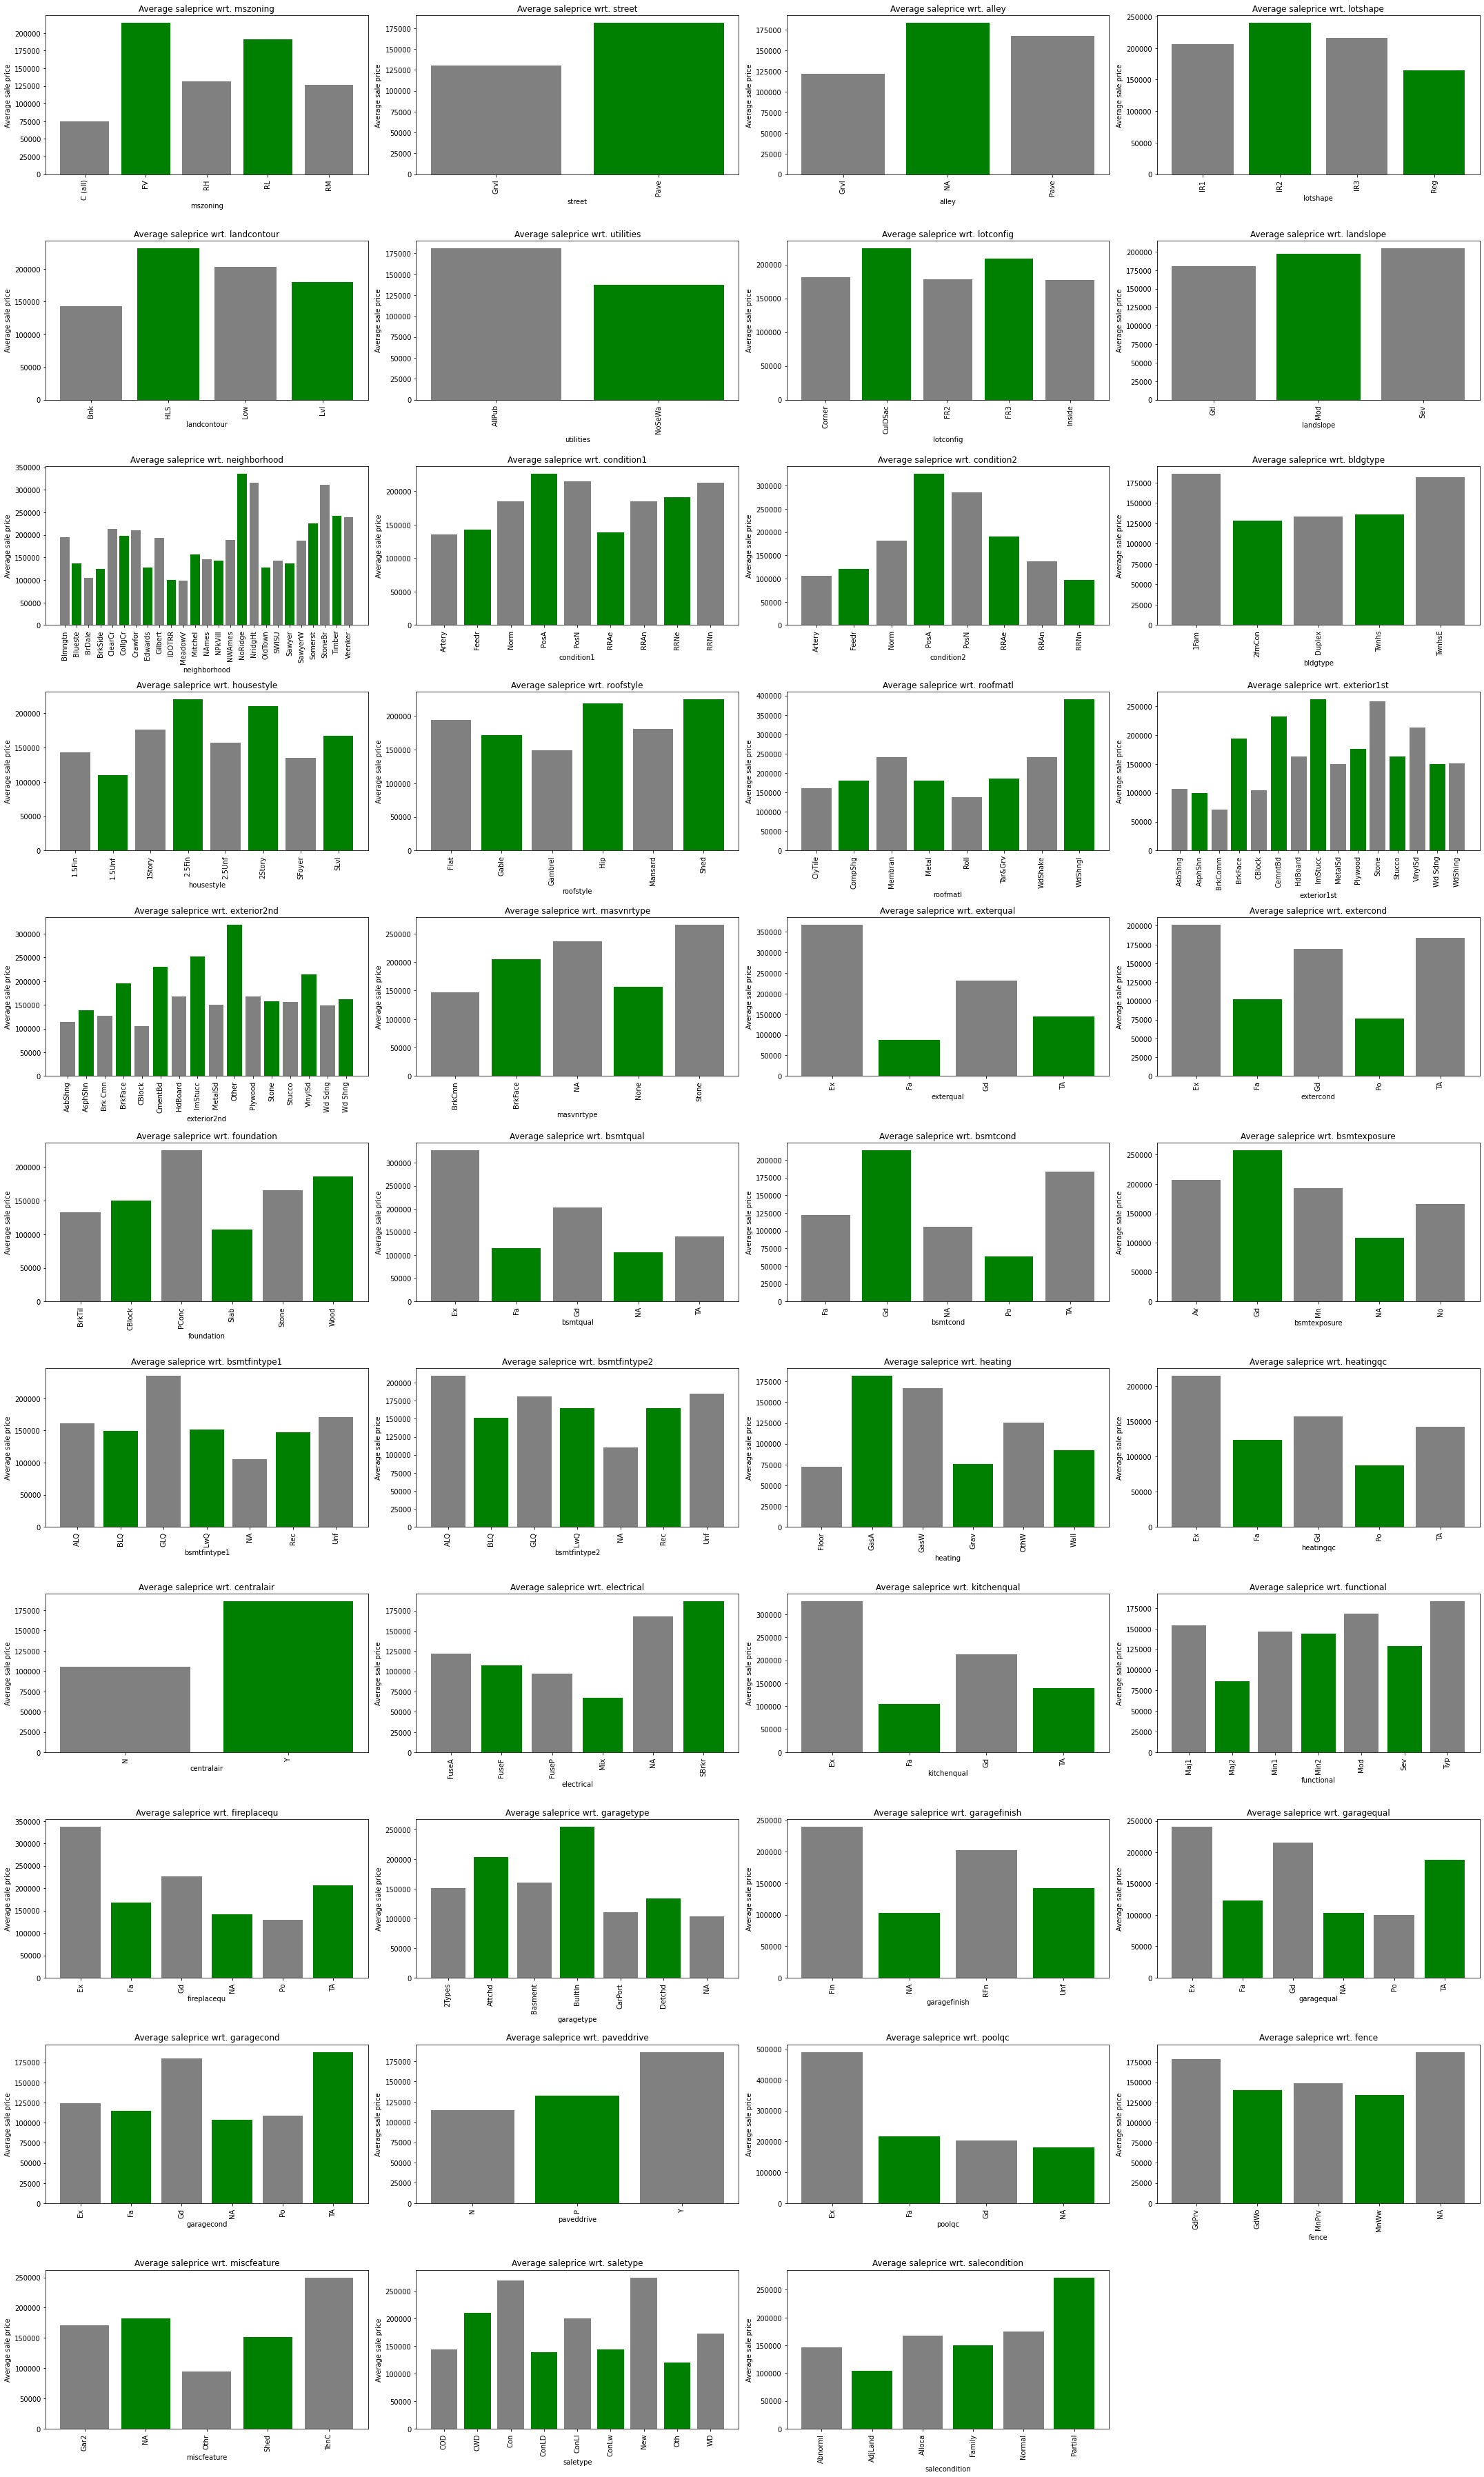

In [ ]:
#To understand the univariate relation between our target variable and non-numerical features; we plot each feature against the target variable. In the charts below, we show the average sale prices with respect to the each categories of a feature.


plt.figure(figsize=(30,50))

for index, column in enumerate(non_numeric_columns):
    plt.subplot(11,4,index+1)
    plt.bar(house_prices_df.groupby(column)["saleprice"].mean().index, house_prices_df.groupby(column)["saleprice"].mean(),
           color=("grey","green"))
    plt.title("Average saleprice wrt. {}".format(column))
    plt.ylabel("Average sale price")
    plt.xlabel(column)
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

As our model, we choose the 5 numerical variables that are most correlated with the sale price. We also add two non-numerical features exterior2nd and neighborhood to our model as their values exhibit some variance with respect to the average sale price. In order to use them in our model, we need to convert them to dummy variables.

In [ ]:
#Extirior 2nd, neighborhood
house_prices_df = pd.concat([house_prices_df,pd.get_dummies(house_prices_df.exterior2nd, prefix="exterior2nd", drop_first=True)], axis=1)
house_prices_df = pd.concat([house_prices_df,pd.get_dummies(house_prices_df.neighborhood, prefix="neighborhood", drop_first=True)], axis=1)
dummy_column_names = list(pd.get_dummies(house_prices_df.exterior2nd, prefix="exterior2nd", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(house_prices_df.neighborhood, prefix="neighborhood", drop_first=True).columns)

In [ ]:
#regression model
X = house_prices_df[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf'] + dummy_column_names]
Y = house_prices_df.saleprice
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     139.8
Date:                Fri, 30 Apr 2021   Prob (F-statistic):               0.00
Time:                        12:23:35   Log-Likelihood:                -17320.
No. Observations:                1460   AIC:                         3.473e+04
Df Residuals:                    1415   BIC:                         3.497e+04
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -5.873e+04   1.35e+04     -4.342      0.000   -8.53e+04   -3.22e+04
overallqual           1.598e+04   1173.119     13.618      0.000    1.37e+04    1.83e+04
grlivarea               46.7649      2.502     18.694      0.000      41.858      51.672
garagecars            1.004e+04   2926.410      3.430      0.001    4297.243    1.58e+04
garagearea              13.9235      9.989      1.394      0.164      -5.672      33.519
totalbsmtsf             22.4281      2.798      8.017      0.000      16.940      27.916
exterior2nd_AsphShn   1.545e+04   2.18e+04      0.709      0.478   -2.73e+04    5.82e+04
exterior2nd_Brk Cmn  -7767.7869   1.89e+04     -0.411      0.681   -4.48e+04    2.93e+04
exterior2nd_BrkFace   1.888e+04   1.07e+04      1.757      0.079   -2199.944       4e+04
exterior2nd_CBlock    1.335e+04   3.59e+04      0.372      0.710    -5.7e+04    8.37e+04
exterior2nd_CmentBd   2.772e+04   9951.379      2.786      0.005    8199.885    4.72e+04
exterior2nd_HdBoard   6301.7666   8499.470      0.741      0.459   -1.04e+04     2.3e+04
exterior2nd_ImStucc    3.17e+04    1.4e+04      2.268      0.023    4287.036    5.91e+04
exterior2nd_MetalSd   5182.7208   8279.381      0.626      0.531   -1.11e+04    2.14e+04
exterior2nd_Other     1.264e+04   3.66e+04      0.345      0.730   -5.92e+04    8.44e+04
exterior2nd_Plywood   6673.3027   8626.266      0.774      0.439   -1.02e+04    2.36e+04
exterior2nd_Stone    -8479.3444   1.78e+04     -0.475      0.635   -4.35e+04    2.65e+04
exterior2nd_Stucco   -1.408e+04   1.06e+04     -1.331      0.183   -3.48e+04    6665.954
exterior2nd_VinylSd   1.261e+04   8370.747      1.507      0.132   -3807.294     2.9e+04
exterior2nd_Wd Sdng   6022.6248   8302.669      0.725      0.468   -1.03e+04    2.23e+04
exterior2nd_Wd Shng   -236.9124   9797.192     -0.024      0.981   -1.95e+04     1.9e+04
neighborhood_Blueste -1.068e+04   2.63e+04     -0.405      0.685   -6.24e+04     4.1e+04
neighborhood_BrDale      -2e+04   1.28e+04     -1.562      0.118   -4.51e+04    5109.714
neighborhood_BrkSide  7881.3233   1.03e+04      0.767      0.443   -1.23e+04     2.8e+04
neighborhood_ClearCr  3.475e+04   1.13e+04      3.088      0.002    1.27e+04    5.68e+04
neighborhood_CollgCr  1.557e+04   9079.547      1.715      0.086   -2236.126    3.34e+04
neighborhood_Crawfor  3.534e+04   1.03e+04      3.416      0.001     1.5e+04    5.56e+04
neighborhood_Edwards   573.4380   9778.733      0.059      0.953   -1.86e+04    1.98e+04
neighborhood_Gilbert  1.235e+04   9492.150      1.301      0.193   -6266.413     3.1e+04
neighborhood_IDOTRR  -7954.2949    1.1e+04     -0.723      0.470   -2.96e+04    1.36e+04
neighborhood_MeadowV -1.847e+04    1.4e+04     -1.321      0.187   -4.59e+04    8956.716
neighborhood_Mitchel  5061.1697   1.02e+04      0.498    

In [ ]:
#some neighborhoods and exterior finishes are important

new_dummies=['neighborhood_Veenker','neighborhood_Timber','neighborhood_StoneBr','neighborhood_Somerst','neighborhood_NridgHt','neighborhood_NoRidge','neighborhood_Crawfor','neighborhood_ClearCr','neighborhood_ClearCr','exterior2nd_ImStucc','exterior2nd_CmentBd']

In [ ]:
#regression model
X = house_prices_df[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf'] + new_dummies]
Y = house_prices_df.saleprice
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     383.8
Date:                Fri, 30 Apr 2021   Prob (F-statistic):               0.00
Time:                        12:43:31   Log-Likelihood:                -17371.
No. Observations:                1460   AIC:                         3.477e+04
Df Residuals:                    1444   BIC:                         3.486e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -6.317e+04   4911.853    -12.861      0.000   -7.28e+04   -5.35e+04
overallqual           1.852e+04   1077.744     17.188      0.000    1.64e+04    2.06e+04
grlivarea               42.4181      2.408     17.618      0.000      37.695      47.141
garagecars            1.364e+04   2789.928      4.888      0.000    8165.091    1.91e+04
garagearea              11.9985      9.743      1.232      0.218      -7.113      31.110
totalbsmtsf             25.8682      2.718      9.516      0.000      20.536      31.200
neighborhood_Veenker  4.276e+04   1.09e+04      3.925      0.000    2.14e+04    6.41e+04
neighborhood_Timber   2.353e+04   6066.235      3.879      0.000    1.16e+04    3.54e+04
neighborhood_StoneBr  6.045e+04   7598.091      7.956      0.000    4.55e+04    7.54e+04
neighborhood_Somerst  1.547e+04   4326.995      3.575      0.000    6981.148     2.4e+04
neighborhood_NridgHt  5.744e+04   4836.524     11.877      0.000     4.8e+04    6.69e+04
neighborhood_NoRidge  6.073e+04   6221.092      9.762      0.000    4.85e+04    7.29e+04
neighborhood_Crawfor  2.687e+04   5203.434      5.164      0.000    1.67e+04    3.71e+04
neighborhood_ClearCr  1.441e+04   3458.453      4.166      0.000    7622.702    2.12e+04
neighborhood_ClearCr  1.441e+04   3458.453      4.166      0.000    7622.702    2.12e+04
exterior2nd_ImStucc   1.969e+04   1.15e+04      1.714      0.087   -2850.331    4.22e+04
exterior2nd_CmentBd   1.102e+04   4829.752      2.282      0.023    1546.869    2.05e+04
==============================================================================
Omnibus:                      384.918   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            26236.740
Skew:                          -0.167   Prob(JB):                         0.00
Kurtosis:                      23.765   Cond. No.                     4.98e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.35e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [ ]:
#Now, split your data into train and test sets where 20% of the data resides in the test set.
#Build several linear regression models including lasso, ridge, or elastic net, and train them in the training set. Use k-fold cross-validation to select the best hyperparameters if your models include one.

house_prices_df = pd.concat([house_prices_df,pd.get_dummies(house_prices_df.exterior2nd, prefix="exterior2nd", drop_first=True)], axis=1)
house_prices_df = pd.concat([house_prices_df,pd.get_dummies(house_prices_df.neighborhood, prefix="neighborhood", drop_first=True)], axis=1)

In [ ]:
house_prices_df['totalsf'] = house_prices_df['totalbsmtsf'] + house_prices_df['firstflrsf'] + house_prices_df['secondflrsf']

house_prices_df['int_over_sf'] = house_prices_df['totalsf'] * house_prices_df['overallqual']

# Y is the target variable
Y = np.log1p(house_prices_df['saleprice'])
# X is the feature set
X = house_prices_df[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalsf', 'int_over_sf'] + new_dummies]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

In [ ]:
lrm = LinearRegression()

lrm.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model in training set is: 0.8274560311681242
-----Test set statistics-----
R-squared of the model in test set is: 0.7999585621938556
Mean absolute error of the prediction is: 0.1365842293413576
Mean squared error of the prediction is: 0.0333560393372506
Root mean squared error of the prediction is: 0.18263635820189417
Mean absolute percentage error of the prediction is: 1.141057521290987


In [ ]:

lasso_cv = LassoCV(alphas=alphas, cv=5)

lasso_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lasso_cv.predict(X_train)
y_preds_test = lasso_cv.predict(X_test)

print("Best alpha value is: {}".format(lasso_cv.alpha_))
print("R-squared of the model in training set is: {}".format(lasso_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lasso_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 1e-10
R-squared of the model in training set is: 0.827456031168124
-----Test set statistics-----
R-squared of the model in test set is: 0.7999585631250021
Mean absolute error of the prediction is: 0.13658422892105135
Mean squared error of the prediction is: 0.03335603918198596
Root mean squared error of the prediction is: 0.18263635777682918
Mean absolute percentage error of the prediction is: 1.141057517952555


In [ ]:
ridge_cv = RidgeCV(alphas=alphas, cv=5)

ridge_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)

print("Best alpha value is: {}".format(ridge_cv.alpha_))
print("R-squared of the model in training set is: {}".format(ridge_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(ridge_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 0.1
R-squared of the model in training set is: 0.8274558293076986
-----Test set statistics-----
R-squared of the model in test set is: 0.8000337730601265
Mean absolute error of the prediction is: 0.136546797866914
Mean squared error of the prediction is: 0.033343498252556183
Root mean squared error of the prediction is: 0.18260202149088103
Mean absolute percentage error of the prediction is: 1.1407564206736


In [ ]:

elasticnet_cv = ElasticNetCV(alphas=alphas, cv=5)

elasticnet_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticnet_cv.predict(X_train)
y_preds_test = elasticnet_cv.predict(X_test)

print("Best alpha value is: {}".format(elasticnet_cv.alpha_))
print("R-squared of the model in training set is: {}".format(elasticnet_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(elasticnet_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 1e-10
R-squared of the model in training set is: 0.8274560311681242
-----Test set statistics-----
R-squared of the model in test set is: 0.7999585626671153
Mean absolute error of the prediction is: 0.13658422912829993
Mean squared error of the prediction is: 0.033356039258336606
Root mean squared error of the prediction is: 0.18263635798585287
Mean absolute percentage error of the prediction is: 1.1410575195971717


In [ ]:

#all models performed well, linear regression was only slightly better

In [ ]:
house_prices_df.yrsold.unique()

array([2008, 2007, 2006, 2009, 2010], dtype=int64)

In [ ]:
avg_int_data = [[2006, 6.41], [2007, 6.34],[2008,6.03], [2009, 5.04],[2010,4.69]]

In [ ]:
avg_int = pd.DataFrame(avg_int_data, columns = ['yrsold', 'rate'])

In [ ]:
house_prices_df=house_prices_df.merge(avg_int, on='yrsold', how='left')

So far, you have only used the features in the dataset. However, house prices can be affected by many factors like economic activity and the interest rates at the time they are sold. So, try to find some useful factors that are not included in the dataset. Integrate these factors into your model and assess the prediction performance of your model. Discuss the implications of adding these external variables into your model.

In [ ]:
# Y is the target variable
Y = np.log1p(house_prices_df['saleprice'])
# X is the feature set
X = house_prices_df[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalsf', 'int_over_sf','rate'] + new_dummies]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

In [ ]:
lrm = LinearRegression()

lrm.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model in training set is: 0.827458015698075
-----Test set statistics-----
R-squared of the model in test set is: 0.7998843590785315
Mean absolute error of the prediction is: 0.1365772301979914
Mean squared error of the prediction is: 0.03336841238385955
Root mean squared error of the prediction is: 0.18267022850990128
Mean absolute percentage error of the prediction is: 1.1410092764997284


by including interest rate in our model we improved the model. Iterest is a singnificant variable.